In [1]:
!pip install patchify

import os
import glob
import cv2
import numpy as np
import skimage.io
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import tensorflow as tf
import random

np.random.seed(0) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
PATH = '/content/drive/MyDrive/AV_split/'
TRAIN_PATH = PATH+'train/'
TRAIN_IMAGE_PATH = TRAIN_PATH + 'images/'
TRAIN_VESSEL_MASK_PATH = TRAIN_PATH + 'GT_vessel/'

TEST_PATH = PATH+'test/'
TEST_IMAGE_PATH = TEST_PATH + 'images/'
TEST_VESSEL_MASK_PATH = TEST_PATH + 'GT_vessel/'

TARGET_SIZE = 512
PATCH_SIZE = 512

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def clahe_equalized(imgs):    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))    
    imgs_equalized = clahe.apply(imgs)

    return imgs_equalized

def preprocess_img(image, patch_size):
    image = image[70:970, 200:1255]

    image = image[:,:,1]
    image = clahe_equalized(image)

    SIZE_X = (image.shape[1]//patch_size)*patch_size 
    SIZE_Y = (image.shape[0]//patch_size)*patch_size     
    image = cv2.resize(image, (SIZE_X, SIZE_Y))
    
    image = np.array(image)

    return image

In [6]:
def preprocess_mask(mask, patch_size):
    thresh = 128
    mask = cv2.threshold(mask, thresh, 255, cv2.THRESH_BINARY)[1]

    mask = mask[70:970, 200:1255]
    
    SIZE_X = (mask.shape[1]//patch_size)*patch_size 
    SIZE_Y = (mask.shape[0]//patch_size)*patch_size     
    mask = cv2.resize(mask, (SIZE_X, SIZE_Y))
  
    mask = 255 - mask

    return mask

In [7]:
def create_patch_image_list(preprocessed_img, patch_size, type):
    patches_img = patchify(preprocessed_img, (patch_size,patch_size), step=patch_size) 
    img_patches_list = []

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patched_img = patches_img[i,j,:,:]
            single_patched_img = (single_patched_img).astype('float32') / 255.
            if type == "MASK":
                single_patched_img[single_patched_img > 0.5] = 1
                single_patched_img[single_patched_img <= 0.5] = 0
            img_patches_list.append(single_patched_img) 

    unpatched_img = unpatchify(patches_img, preprocessed_img.shape)

    return img_patches_list, unpatched_img

In [8]:
train_image_list = glob.glob(TRAIN_IMAGE_PATH + '/*.JPG')
train_image_list.sort()

train_vessel_mask_list = glob.glob(TRAIN_VESSEL_MASK_PATH + '/*.jpg')
train_vessel_mask_list.sort()

0.007843138 0.9843137
(2, 512, 512)


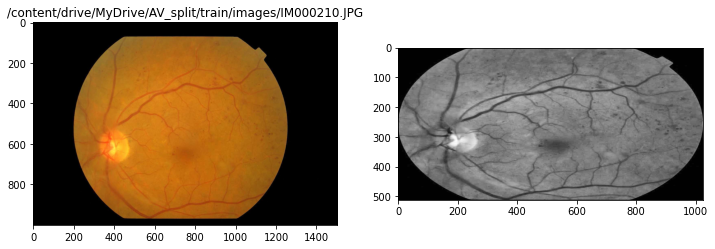

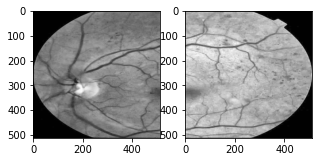

In [9]:
image = cv2.imread(train_image_list[10])

preprocessed_image = preprocess_img(image, PATCH_SIZE)
patched_image, unpatchifed_image = create_patch_image_list(preprocessed_image, PATCH_SIZE, "IMAGE")
patched_image = np.array(patched_image)

print(patched_image.min(), patched_image.max())
print(patched_image.shape)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(train_image_list[10])
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(unpatchifed_image, cmap='gray')

plt.show()

rows = 1
columns = patched_image.shape[0]

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    fig.add_subplot(rows, columns, i)
    img = patched_image[i-1]
    plt.imshow(img,cmap='gray')

plt.show()

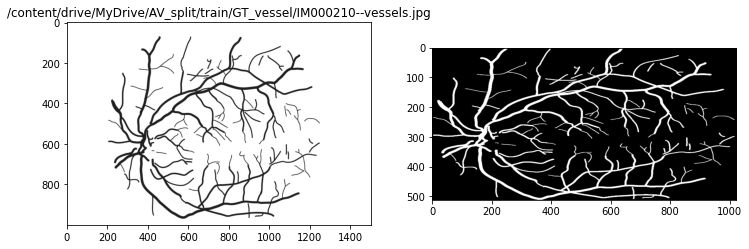

0.0 1.0
(2, 512, 512)
[0. 1.]


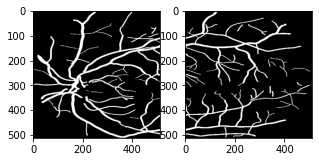

In [10]:
vessel_mask = cv2.imread(train_vessel_mask_list[10], cv2.IMREAD_GRAYSCALE)

preprocessed_vessel_mask = preprocess_mask(vessel_mask, PATCH_SIZE)
patched_mask, unpatcified_mask = create_patch_image_list(preprocessed_vessel_mask, PATCH_SIZE, "MASK")
patched_mask = np.array(patched_mask)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(train_vessel_mask_list[10])
plt.imshow(cv2.cvtColor(vessel_mask, cv2.COLOR_BGR2RGB))
plt.subplot(122)
plt.imshow(unpatcified_mask, cmap='gray')

plt.show()

print(patched_mask.min(), patched_mask.max())
print(patched_mask.shape)
print(np.unique(patched_mask))

rows = 1
columns = patched_image.shape[0]

fig = plt.figure(figsize=(5, 5))
for i in range(1, (rows * columns + 1)):
    fig.add_subplot(rows, columns, i)
    img = patched_mask[i-1]
    plt.imshow(img,cmap='gray')

plt.show()

In [11]:
train_image_dataset = []
train_vessel_mask_dataset = []

for image_name in train_image_list:
    image = cv2.imread(image_name)
    preprocessed_image = preprocess_img(image, PATCH_SIZE)
    patched_image, unpatchifed_image = create_patch_image_list(preprocessed_image, PATCH_SIZE, "IMAGE")
    train_image_dataset += patched_image

for mask_name in train_vessel_mask_list:
    mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
    preprocessed_mask = preprocess_mask(mask, PATCH_SIZE)
    patched_mask, unpatcified_mask = create_patch_image_list(preprocessed_mask, PATCH_SIZE, "MASK")
    train_vessel_mask_dataset += patched_mask

train_image_dataset = np.array(train_image_dataset)
train_image_dataset = np.expand_dims(train_image_dataset, axis=-1)
train_vessel_mask_dataset = np.array(train_vessel_mask_dataset)
train_vessel_mask_dataset = np.expand_dims(train_vessel_mask_dataset, axis=-1)

print(train_image_dataset.shape)
print(train_vessel_mask_dataset.shape)
print(train_image_dataset.max(), train_vessel_mask_dataset.max())
print(train_image_dataset.min(), train_vessel_mask_dataset.min())

(50, 512, 512, 1)
(50, 512, 512, 1)
1.0 1.0
0.003921569 0.0


In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_image_dataset, train_vessel_mask_dataset, test_size=0.3, random_state=0)

In [13]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(35, 512, 512, 1) (35, 512, 512, 1)
(15, 512, 512, 1) (15, 512, 512, 1)


In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)

In [15]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def unet(pretrained_weights = None,input_size = (512,512,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2,padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', dilation_rate=2, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4, training=True)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5, training=True)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = IoU_loss, metrics = ['accuracy', IoU_coef])
    

    if(pretrained_weights):
    	  model=keras.models.load_model(pretrained_weights)

    return model

In [16]:
model = unet(input_size=(PATCH_SIZE, PATCH_SIZE, 1))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
history = model.fit(x_train, y_train, 
                    verbose = 1,
                    batch_size = 3,
                    validation_data = (x_test, y_test), 
                    shuffle = False,
                    epochs = 150,
                    steps_per_epoch = 10)

Epoch 1/150
10/10 [==============================] - 40s 1s/step - loss: -0.1314 - accuracy: 0.3667 - IoU_coef: 0.1314 - val_loss: -0.0915 - val_accuracy: 0.7860 - val_IoU_coef: 0.0915
Epoch 2/150
10/10 [==============================] - 26s 3s/step - loss: -0.1565 - accuracy: 0.7531 - IoU_coef: 0.1564 - val_loss: -0.0930 - val_accuracy: 0.8151 - val_IoU_coef: 0.0930
Epoch 3/150
10/10 [==============================] - 13s 1s/step - loss: -0.1608 - accuracy: 0.8228 - IoU_coef: 0.1608 - val_loss: -0.0925 - val_accuracy: 0.8893 - val_IoU_coef: 0.0925
Epoch 4/150
10/10 [==============================] - 14s 1s/step - loss: -0.1618 - accuracy: 0.8365 - IoU_coef: 0.1618 - val_loss: -0.0924 - val_accuracy: 0.8929 - val_IoU_coef: 0.0924
Epoch 5/150
10/10 [==============================] - 13s 1s/step - loss: -0.1687 - accuracy: 0.8532 - IoU_coef: 0.1686 - val_loss: -0.0931 - val_accuracy: 0.8915 - val_IoU_coef: 0.0931
Epoch 6/150
10/10 [==============================] - 14s 1s/step - loss: -0

In [18]:
test_image_list = glob.glob(TEST_IMAGE_PATH + '/*.JPG')
test_image_list.sort()

test_vessel_mask_list = glob.glob(TEST_VESSEL_MASK_PATH + '/*.jpg')
test_vessel_mask_list.sort()

1/1 [==============================] - 0s 27ms/step


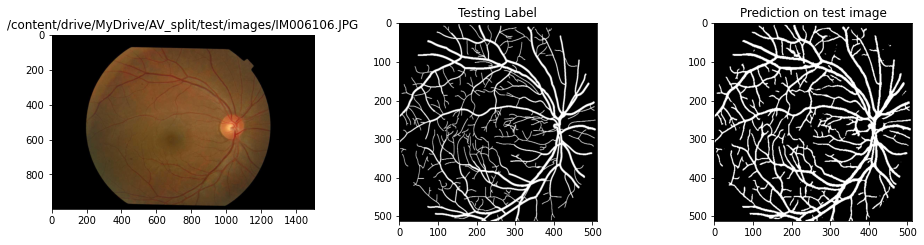

In [28]:
test_img_number = random.randint(0, len(test_image_list)-1)

test_img = cv2.imread(train_image_list[test_img_number])
test_gt = cv2.imread(train_vessel_mask_list[test_img_number], cv2.IMREAD_GRAYSCALE)

test_img_preprocess = preprocess_img(test_img, PATCH_SIZE)
test_gt = preprocess_mask(test_gt, PATCH_SIZE)

test_patches = patchify(test_img_preprocess, (PATCH_SIZE, PATCH_SIZE), step=PATCH_SIZE)
predicted_patches = []

for i in range(test_patches.shape[0]):
      for j in range(test_patches.shape[1]):
          single_patch = test_patches[i,j,:,:]
          single_patch_norm = (single_patch.astype('float32')) / 255.
          single_patch_norm = np.expand_dims(np.array(single_patch_norm), axis=-1)
          single_patch_input = np.expand_dims(single_patch_norm, 0)
          single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8) 
          predicted_patches.append(single_patch_prediction)

predicted_patches = np.array(predicted_patches)
predicted_patches_reshaped = np.reshape(predicted_patches, (test_patches.shape[0], test_patches.shape[1], PATCH_SIZE, PATCH_SIZE))
reconstructed_image = unpatchify(predicted_patches_reshaped, test_gt.shape)
reconstructed_image = cv2.resize(reconstructed_image, (PATCH_SIZE, PATCH_SIZE))
test_gt = cv2.resize(test_gt, (PATCH_SIZE, PATCH_SIZE))

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title(test_image_list[test_img_number])
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_gt, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(reconstructed_image, cmap='gray')